In [1]:
# An example plotting script for DCMIP 2025 test case 2b: vortex shedding

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import matplotlib
import matplotlib.colors as colors
import metpy.calc as mpc
import xarray as xr
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Parameters from the simulation:
rot = False
u0 = 10
T0 = 288
h_val = 1500
a_val = 500
small_earth_fact = 20.0
cor = 7.29211e-5 * small_earth_fact
mountain_center_lat = 20 # deg
mountain_center_lon = 90 # deg
mountain_radius = 12.5 # km
mountain_height = 1.5 # km

In [4]:
# Information about the paths
model = 'SE' # or 'FV3' or 'MPAS'
vert = 'hydrostatic' # or 'nonhydrostatic'

# Name of your CAM clone:
CAM_dirname = 'CAM_6_4_060_06032025'

# Edit this to your own case name
case = 'cam_6_4_060_horiz_mount_flow_se_ne60_L30km_L38'

# Modify the following according to your naming convention
if rot:
    nc_file = case + f'.cam.h0i.0001-01-01-00000_vortex_with_rot_RF_15km_tau_1_10th_day.nc'
else:
    nc_file = case + f'.cam.h0i.0001-01-01-00000_vortex_omega0_RF_15km_tau_1_10th_day.nc'

# Define the base root to the data, add your username
username = 'timand'
run_base = f'/glade/derecho/scratch/{username}/'
output_base = f'/glade/u/home/{username}/'

In [5]:
# Automatically set some paths
run_path = run_base + case + '/run/' + nc_file
output_dir = f'{CAM_dirname}/plotting/'
output_file = output_base + output_dir

In [6]:
nc = Dataset(run_path)
ds = xr.open_dataset(run_path)

In [7]:
# Specify the altitude, field and times you want to plot
z_val = 300 # in metres, over 300
field = 'vor' # modify this! options = 'U', 'V', 'W', 'T', 'vor', 'div'
t_idxs = [20, 40, 60, 80] # Each index is 0.25 small Earth hours, can modify, up to 80
mountain_observed_radius = mountain_radius*np.sqrt(-np.log((z_val/1000.0)/mountain_height))
mountain_radius_degrees = mountain_observed_radius / (6371.0/small_earth_fact) * 180.0/np.pi

In [8]:
# Extract the data
time_stamps = nc['time'][:]
lats = nc['lat'][:]
lons = nc['lon'][:]
levs = nc['lev'][:]

print(f'There are {len(time_stamps)} time samples')
print(f'{len(lats)} latitiude points, {len(lons)} longitude points')

There are 81 time samples
513 latitiude points, 1024 longitude points


In [9]:
# Crop to the subdomain of interest

lon_crop_left = 70.
lon_crop_right = 250.
lon_ticks = np.linspace(80, 220, 8) # Plotting ticks

lat_crop_up = 40.
lat_crop_down = 0.
lat_ticks = np.linspace(0,40,5) # Plotting ticks


lon_inds = np.where((lons > lon_crop_left) & (lons < lon_crop_right))[0]
lat_inds = np.where((lats > lat_crop_down) & (lats < lat_crop_up))[0]

print(f'Crop is of size, {len(lat_inds)} lat vals and {len(lon_inds)} lon vals')

lat_slice = lats[lat_inds] 
lon_slice = lons[lon_inds] 
LON_subset, LAT_subset = np.meshgrid(lon_slice, lat_slice)

Crop is of size, 113 lat vals and 512 lon vals


In [11]:
# Interpolate the data at each time index:
if (model == "MPAS"):
    if (field == "vor" or field == "div"):
        uv = ds.isel(time=t_idxs, lat=lat_inds, lon=lon_inds).interp(lev=z_val, method='linear')
        if (field == "vor"):
            field_vals = mpc.vorticity(uv['U'], uv['V'])
        else:
            field_vals = mpc.divergence(uv['U'], uv['V'])
    elif (field == "W"):
        field_vals = ds['w'].isel(time=t_idxs, lat=lat_inds, lon=lon_inds).interp(lev=z_val, method='linear')
    else:
        field_vals = ds[field].isel(time=t_idxs, lat=lat_inds, lon=lon_inds).interp(lev=z_val, method='linear')
else:
    if (field == "vor" or field == "div"):
        uv = np.zeros((len(t_idxs), 2, len(lat_slice), len(lon_slice)))
        for i in range(len(t_idxs)):
            uv[i] = z_interp_uv(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['U'][t_idxs[i], :, lat_inds, lon_inds], nc['V'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))
        uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), coords = dict(time=time_stamps[t_idxs], lat=lat_slice, lon=lon_slice))
        uv_ds['U'].attrs["units"] = "m/s"
        uv_ds['V'].attrs["units"] = "m/s"
        if (field == "vor"):
            field_vals = mpc.vorticity(uv_ds['U'], uv_ds['V'])
        else:
            field_vals = mpc.divergence(uv_ds['U'], uv_ds['V'])
    elif (field == "W"):
        field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
        if (vert == 'hydrostatic'):
            for i in range(len(t_idxs)):
                field_vals[i] = z_interp_w_hydrostatic(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                print('interpolated time ' + str(i+1))
        else: 
            for i in range(len(t_idxs)):
                field_vals[i] = z_interp_w_nonhydro(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                print('interpolated time ' + str(i+1))
    else:
        field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
        for i in range(len(t_idxs)):
            field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc[field][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))

interpolated time 1
interpolated time 2
interpolated time 3
interpolated time 4


In [12]:
# compute the perturbations
if field == 'U':
    # Normalised wind perturbation
    LAT_subset_rad = np.deg2rad(LAT_subset)
    field_vals = (field_vals - u0*np.cos(LAT_subset_rad)) / (u0*np.cos(LAT_subset_rad))
elif field == 'T':
    # temperature perturbation
    field_vals = field_vals - T0

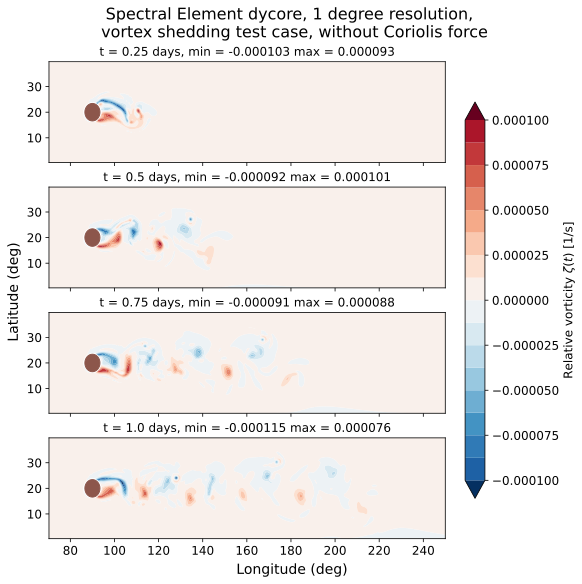

In [13]:
# Make the plot!
fig, axes = plt.subplots(len(t_idxs),1, figsize=(8.0,8.0*len(t_idxs)/4.0), sharex=True, layout='constrained')

title_size=16
label_size=14
small_size=12
round_dig = 2

# For the title
dycore_res = 'SE ne60'

# for the color map
norm = MidpointNormalize(midpoint = 0, vmin = np.nanmin(field_vals), vmax = np.nanmax(field_vals))
cmap_choice = 'RdBu_r'
levels = 15

fix_minmax = True

# Feel free to add additional fields, such as V, OMEGA
if field == 'T':
    title = 'Temperature perturbation'
    cb_label = '$T - T_0$ [K]'
    min = -2
    max = 5
elif field == 'U':
    title = 'Normalised zonal velocity perturbation'
    cb_label = '$(u(t) - u_0)/u_0$ [m/s]'
    min = -1.5
    max = 0.6
elif field == 'V':
    title = "Meridional velocity"
    cb_label = '$v(t)$ [m/s]'
    min = -9
    max = 9
elif field == 'W':
    title = "Vertical velocity"
    cb_label = '$w(t)$ [m/s]'
    min = -0.2
    max = 0.36
elif field == "vor":
    title = "Relative vorticity"
    cb_label = '$\zeta(t)$ [1/s]'
    round_dig = 6
    min = -0.0001
    max = 0.0001
elif field == "div":
    title = "Fluid divergence"
    cb_label = '$\sigma(t)$ [1/s]'
    round_dig = 6
    min = -0.00003
    max = 0.00003

if fix_minmax:
    levels = 17
    levels = np.mgrid[min:max:levels*1j]
else:
    levels = 15
    valmin = round(valmin, -int(floor(log10(abs(valmin)))))
    valmax = round(valmax, -int(floor(log10(abs(valmax)))))
    levels = np.mgrid[valmin:valmax:levels*1j]

for ind, ax in enumerate(np.ravel(axes)):
    if fix_minmax:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm, extend='both')
    else:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm)
    # ax.set_aspect('equal')
    ax.tick_params(axis='both', labelsize=small_size)
    ax.set_title(f't = {time_stamps[t_idxs[ind]]} days, min = ' + '%.*f' % (round_dig, np.nanmin(field_vals[ind])) + ' max = ' + '%.*f' % (round_dig, np.nanmax(field_vals[ind])))
    ax.add_patch(plt.Circle((mountain_center_lon, mountain_center_lat), 1.2*mountain_radius_degrees, color='tab:brown'))

cb = plt.colorbar(plot, ax=axes, fraction=0.05*len(t_idxs)/4.0)
cb.set_label(label=title + " " + cb_label, size=small_size)
cb.ax.tick_params(labelsize=small_size)

fig.supylabel('Latitude (deg)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

if rot:
    fig.suptitle('Spectral Element dycore, 1 degree resolution, \n vortex shedding test case, with Coriolis force', size=title_size)
else:
    fig.suptitle('Spectral Element dycore, 1 degree resolution, \n vortex shedding test case, without Coriolis force', size=title_size)

plt.show()